In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import copy
import time
from operator import add
from tqdm import tqdm # Pour avoir une barre de chargement lors de l'exécution
import pandas as pd
import pylab
import gurobipy as gp 
from gurobipy import GRB


## Définition des fonctions de lecture d'instance et d'affichage

In [2]:
def LectureInstance(nomFichier):
    """Fonction permettant de lire les instances (quelque soit le nombre de critères (séparés par un espace dans le fichier))
    Paramètres : nomFichier le nom du fichier d'instance
    Retourne n le nombre d'objets, W la capacité du sac à dos, w la liste de poids des objets, et v la liste de vecteur
    de valuation des objets (sous la forme [liste des valuations de l'objet 1, liste des valuations de l'objet 2, ...])"""
    # Lecture du fichier
    with open(nomFichier, 'r') as f:
        allLines = f.readlines()
        
    nbLignesPassees = 0 # Le nombre de lignes sautées (car commentaires ou définition de valeur de n ou de W)

    for i, line in enumerate(allLines): # On parcourt les lignes du fichiers
        if line[0] == 'i': # On met à jour les données de l'objet du numéro de ligne - le nombre de lignes passées
            objets[i-nbLignesPassees] = list(map(int, line.rstrip().lstrip("i ").split(" ")))
        else:
            nbLignesPassees += 1 # On augmente le nombre de lignes passées
            if line[0] == 'n':
                n = int(line[1:])
                # Maintenant que l'on a récupéré n, on peut récupérer le nombre de colonnes (et donc de critères) sur la ligne suivante
                taille = len(allLines[i+1].rstrip().lstrip("c ").split(" "))
                objets = np.empty((n, taille)) 
            if line[0] == 'W':             
                W = int(line[1:])

    return n, W, objets[:, 0], objets[:, 1:]

def LectureInstanceParticuliere(nomFichier, nbObj, nbCrit):
    """Fonction permettant de lire les instances en précisant le nombre d'objets et le nombre de critères souhaités (si on souhaite plus d'objets 
    (ou de critères) qu'il y en a dans le fichier, on prendra touts les objets (ou critères) du fichier en entrée)
    Paramètres : nomFichier le nom du fichier d'instance
                 nbObj le nombre d'objets souhaités
                 nbCrit le nombre de critères souhaités
    Retourne n le nombre d'objets, W la capacité du sac à dos, w la liste de poids des objets, et v la liste de vecteur
    de valuation des objets (sous la forme [liste des valuations de l'objet 1, liste des valuations de l'objet 2, ...])"""
    # Lecture du fichier
    with open(nomFichier, 'r') as f:
        allLines = f.readlines()
        
    nbLignesPassees = 0 # Le nombre de lignes sautées (car commentaires ou définition de valeur de n ou de W)
    sommeWi = 0 # La somme de poids des objets à considérer

    for i, line in enumerate(allLines): # On parcourt les lignes du fichiers
        if line[0] == 'i': # On met à jour les données de l'objet du numéro de ligne - le nombre de lignes passées
            if i-nbLignesPassees < nbObj: # Sinon, on a déjà assez d'objets (le nombre demandé)
                # On ne prends que nbCrit critères + le poids w pour chaque objet
                objets[i-nbLignesPassees] = list(map(int, line.rstrip().lstrip("i ").split(" ")))[:nbCrit+1] 
                sommeWi += objets[i-nbLignesPassees, 0]
        else:
            nbLignesPassees += 1 # On augmente le nombre de lignes passées
            if line[0] == 'n':
                n = int(line[1:]) # Le nombre d'objets dans le fichier
                # Maintenant que l'on a récupéré n, on peut récupérer le nombre de colonnes (et donc de critères) sur la ligne suivante
                taille = len(allLines[i+1].rstrip().lstrip("c ").split(" "))
                if n < nbObj: # Si nbObj > nombre d'objets dans le fichier 
                    nbObj = n # On retourne alors seulement n objets

                if taille - 1 < nbCrit: # Si nbCrit > nombre de critères dans le fichier
                    nbCrit = taille - 1 # On prend des objets sur seulement le nombre de critères dans le fichier alors

                objets = np.empty((nbObj, nbCrit + 1)) # Les critères en nombre demandé + le poids de l'objet

    W = math.floor(sommeWi/2) # On fixe le W comme indiqué dans l'énoncé
    return nbObj, W, objets[:, 0], objets[:, 1:]
 
# Test
n, W, w, v = LectureInstance("2KP200-TA-0.dat")
# print(n,W,w,v)

n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 3)
print(n,W,w,v)

20 6232 [394. 911. 768. 477. 513. 636. 607. 138. 401. 998. 839. 637. 972. 527.
 891. 807. 949. 193. 349. 458.] [[783. 840. 906.]
 [198. 798. 820.]
 [278. 335. 100.]
 [629. 554. 933.]
 [952. 365. 941.]
 [717. 916. 493.]
 [ 17. 142. 736.]
 [804. 243. 318.]
 [130. 157. 821.]
 [219. 109. 181.]
 [613. 513. 844.]
 [524. 296.  23.]
 [293. 494. 281.]
 [770. 771. 380.]
 [284. 400. 762.]
 [919. 353. 830.]
 [526.  70. 158.]
 [663.  86. 261.]
 [ 65. 890. 365.]
 [ 64.  21.  53.]]


In [5]:
def AfficheSolution(sol, v):
    """Fonction permettant d'afficher de façon claire une solution (les objets à prendre + le vecteur de valuation associé)
    Paramètres : sol une solution, càd un vecteur dans lequel sol[i] vaut 1 si on a pris l'objet i et 0 sinon
                 v est la matrice de valuation des objets sur les différents critères"""
    objetsPris = []
    for ind in range(len(sol)): # On parcourt les objets
        if sol[ind] == 1:
            objetsPris.append(ind)
    print("Objets à prendre : ", objetsPris, " de valuation ", f(sol, v)) 
        
def AfficheSolutions(X, v):
    """Fonction permettant d'afficher de façon claire l'ensemble des solutions (les objets à prendre + le vecteur de valuation associé)
    Paramètres : X un ensemble de solutions (une solution est un vecteur dans lequel sol[i] vaut 1 si on a pris l'objet i et 0 sinon)
                 v est la matrice de valuation des objets sur les différents critères"""
    print("Il y a ", len(X), " solutions :")
    for sol in X: # On parcourt les solutions
        AfficheSolution(sol, v)          

# Une première procédure de résolution

## Définition de la PLS (avec des listes simples)

In [7]:
def popInitiale(W,w):
    """Fonction initialisant la population
    La population initiale sera constituée d’une seule solution réalisable, générée aléatoirement :
    tant qu’il reste de la place dans le sac, un objet choisi aléatoirement (de poids inférieur à la quantité de place restante) est ajouté
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
    Retourne une population initiale sous la fome de liste de liste (liste contenant une seule solution)"""
    Wtemp = W
    n = len(w) # Le nombre d'objets
    Lsol = [0 for i in range(n)]
    tupled = list(zip(w, range(n)))
    sortedByValue = sorted(tupled, key=lambda tup: tup[0])
    objetsPossibles = [(x,y) for x,y in sortedByValue if x<=W]
    while len(objetsPossibles)>0:
        r=random.randint(0,len(objetsPossibles)-1)
        Lsol[objetsPossibles[r][1]]=1
        Wtemp-=objetsPossibles[r][0]
        objetsPossibles.pop(r)
        objetsPossibles=[(x,y) for x,y in objetsPossibles if x<=Wtemp]
    return [Lsol]
    
    
def somme(x,w):
    """Fonction indiquant le poids des objets sélectionnés
    Paramètres : x est le vecteur dans lequel x[i] indique 1 si on a pris l'objet i et 0 sinon
                 w est la liste de poids des objets
    Retourne le poids total des objets sélectionnés"""
    somme = 0
    for k in range(len(x)):
        if(x[k] == 1):
            somme += w[k]
    return somme

def f(x, v):
    """Fonction retournant la valuation de la solution sur tous les critères (on est en maximisation)
    Paramètres : x est le vecteur dans lequel x[i] indique 1 si on a pris l'objet i et 0 sinon
                 v est la matrice de valuation des objets sur les différents critères
    Retourne le vecteur de valuation (gain) de la solution sur tous les critères"""
    nbCriteres = len(v[0]) # nbCriteres est le nombre de critères à considérer
    vecteurCout = [0] * nbCriteres # VecteurCout est le vecteur de valuation (coût ou gain)
    
    for crit in range(nbCriteres): # On parcourt les différents critères
        vecteurCout[crit] = sum([v[i,crit]*x[i] for i in range(len(x))]) # On parcourt tous les objets        
    return vecteurCout

def fList(X, v): # PB pas utilisé
    """Fonction retournant la liste de valuation des solutions sur tous les critères (on est en maximisation)
    Paramètres : X un ensemble de solutions (une solution est un vecteur dans lequel sol[i] vaut 1 si on a pris l'objet i et 0 sinon)
                 v est la matrice de valuation des objets sur les différents critères
    Retourne la liste des vecteurs de valuation (gain) des solutions sur tous les critères"""
    vecteurCoutList = [] # VecteurCoutList est la liste des vecteurs de valuation (coût ou gain)
    
    for sol in X: # On parcourt les solutions
        vecteurCoutList.append(f(sol, v))       
    return vecteurCoutList

def incomparable(a, b, v):
    """Fonction qui renvoie vrai si b et a sont incomparable et faux sinon, càd si l'un domine strictement l'autre
    Paramètres : a est un vecteur dans lequel a[i] indique 1 si on a pris l'objet i et 0 sinon (vecteur caractérisant une solution)
                 b est un autre vecteur caractérisant une solution, càd dans lequel b[i] indique 1 si on a pris l'objet i et 0 sinon
                 v est la matrice de valuation des objets sur les différents critères
    Retourne vrai si b et a sont incomparable et faux sinon, càd si l'un domine strictement l'autre"""
    if(a==b): # PB
        return True # Cas particulier
    
    nbCriteres = len(v[0]) # nbCriteres est le nombre de critères à considérer
    
    f_a=f(a,v)
    f_b=f(b,v)
    
    domine = -1 # domine est un booléen contenant vrai si a meilleur que b et faux sinon
    for crit in range(nbCriteres):
        if(f_a[crit]!= f_b[crit]):
            if(domine == -1): # On initialise le booléen domine
                domine = (f_a[crit]> f_b[crit])
            
            if(f_a[crit]> f_b[crit] and domine == False):
                return True # Ici, b était meilleur que a et a est actuellement meilleur que b (incomparable)
            
            if(f_a[crit]< f_b[crit] and domine == True):
                return True # Ici, a était meilleur que b et b est actuellement meilleur que a (incomparable)
    return False # Ici, a domine b ou b domine a # PB on pourait aussi donner le sens de la domination ici

def domine(a, b, v):
    """Fonction qui renvoie vrai si a domine b et faux sinon
    Paramètres : a est un vecteur dans lequel a[i] indique 1 si on a pris l'objet i et 0 sinon (vecteur caractérisant une solution)
                 b est un autre vecteur caractérisant une solution, càd dans lequel b[i] indique 1 si on a pris l'objet i et 0 sinon
                 v est la matrice de valuation des objets sur les différents critères
    Retourne vrai si a domine b et faux sinon"""
    if(a == b): # Cas particulier d'égalité
        return False
    nbCriteres = len(v[0]) # nbCriteres est le nombre de critères à considérer
    
    f_a=f(a,v)
    f_b=f(b,v)
    
    for crit in range(nbCriteres):
        if(not(f_a[crit]>= f_b[crit])):
            return False # Ici, b est meilleur que a au moins pour un critère (donc a ne domine pas b)
    return True # Ici, b n'est jamais meilleur que a donc a domine b

def non_domine(a, b, v):
    """Fonction qui renvoie vrai si a n'est pas dominé par b et faux sinon, càd si a est dominé par b
    Paramètres : a est un vecteur dans lequel a[i] indique 1 si on a pris l'objet i et 0 sinon (vecteur caractérisant une solution)
                 b est un autre vecteur caractérisant une solution, càd dans lequel b[i] indique 1 si on a pris l'objet i et 0 sinon
                 v est la matrice de valuation des objets sur les différents critères
    Retourne vrai si a n'est pas dominé par b et faux sinon, càd si a est dominé par b"""
    return not(domine(b,a,v))


def MiseAJour(X, x, v):
    """Mise à jour de la liste X en cherchant à ajouter potentiellement x 
    Cette procédure renverra un booléan égal à Vrai si la solution a été ajoutée dans la liste
    Paramètres : X un ensemble de solutions (une solution est un vecteur dans lequel sol[i] vaut 1 si on a pris l'objet i et 0 sinon)
                 x est une nouvelle solution (un vecteur dans lequel x[i] indique 1 si on a pris l'objet i et 0 sinon)
                 v est la matrice de valuation des objets sur les différents critères
    Retourne vrai si on a ajouté x à X et faux sinon (càd si x était dominé par un élément de X)"""
    elemsAenlever = []
    for sol in X:
        if sol == x: # Si x est déjà dans X, on ne l'ajoute pas une seconde fois
            return False
        # On n'ajoute pas une solution si elle a les mêmes valeurs dans l'espace des critères qu'une solution déjà sauvegardée
        # (une solution par valuation dans l'espace des critères suffit)
        if f(sol,v) == f(x,v): 
            # if sol != x: # PB
            #     print("OH")
            # print("sol = ", sol)
            # print("x = ", x)
            # print("f(sol,v) = ", f(sol,v))
            # print("f(x,v) = ", f(x,v))
            return False 
        if domine(sol,x,v):
            return False
        elif domine(x,sol,v):
            elemsAenlever.append(sol) 
            
    for y in elemsAenlever:
        X.remove(y)
        
    X.append(x)
    return True

def Voisin(x, W, w): 
    """Fonction permettant de générer les voisins d'une solution 
    Paramètres : x est le vecteur dans lequel x[i] indique 1 si on a pris l'objet i et 0 sinon
                 W est la capacité du sac
                 w est la liste de poids des objets
    Retourne N la liste des voisins"""
    n = len(x) # Le nombre d'objets
    N = []
    Wrestant = W - sum(w[i]*x[i] for i in range(len(x))) 
    for i in range(n): # On parcourt les objets
        if(x[i]==1):
            Wpossible = Wrestant + w[i] # On enlève le poids de l'objet i
            res = x.copy()
            listOfPossible = [k for k in range(n) if res[k]==0 and w[k]<= Wpossible]
            for j in listOfPossible:
                res2 = res.copy()
                res2[j] = 1
                Wpossible2 = Wpossible - w[j] # On ajoute le poids de l'objet j
                listOfPossible2 = [k for k in range(n) if res2[k]==0 and w[k]<= Wpossible2]
                while listOfPossible2 !=[]:
                    randomi = listOfPossible2[random.randint(0,len(listOfPossible2)-1)]
                    res2[randomi] = 1
                    Wpossible2 = Wpossible2 - w[randomi] # On ajoute le poids de l'objet randomi
                    listOfPossible2 = [k for k in range(n) if res2[k]==0 and w[k]<= Wpossible2]
                res2[i] = 0 # On enlève l'objet i (à la fin pour ne pas pouvoir le reprendre)
                if(res2!=x): # Pour ne pas mettre x lui-même dans le voisinnage de x
                    N.append(res2)
    return N

def PLS(W, w, v, verbose=False):
    """Fonction PLS
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
                 verbose indique si on veut afficher le déroulement (True) ou non (False)
    Retourne une approximation de l’ensemble des solutions efficaces"""
    start = time.time()
    P0 = popInitiale(W, w)
    Xe = P0.copy()
    P = P0.copy()
    Pa = []
    while P != []:
        for p in P:
            voisins = Voisin(p, W, w)
            for pPrime in voisins:
                if non_domine(pPrime, p, v): # PB p!=pPrime and 
                    if MiseAJour(Xe, pPrime, v):
                        MiseAJour(Pa, pPrime, v)

        P = Pa.copy()
        Pa = []
        if verbose:
            print("Taille P:{}, time total: {:.2f} s".format(len(P), time.time()-start))
            # for elem in P:
            #     print("Vecteur valuation = ", f(elem, v))
    return Xe

In [15]:
# Test
# Instance entière (200 objets, 6 critères) : "2KP200-TA-0.dat"
n, W, w, v = LectureInstance("2KP200-TA-0.dat")
# Instance partielle (20 objets, 3 critères) :
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 3)
Xe = PLS(W, w, v)
AfficheSolutions(Xe, v) # Affichage des solutions obtenues

# ListS = [f(k) for k in Xe] # PB affichage pour plus de 2 critères et sans connaître les vrais non dominés
# plt.scatter(*zip(*NonDom),c = 'blue',label='exact')
# plt.scatter(*zip(*ListS),marker = '+',c = 'red',label='approx')
# plt.legend()
# plt.show()

# print("Proportion", PYN(ListS, NonDom)*100,"%")
# print("Distance moyenne", DM(ListS, NonDom))

Il y a  9  solutions :
Objets à prendre :  [0, 3, 4, 5, 7, 8, 10, 13, 15, 16, 17, 18]  de valuation  [7571.0, 5758.0, 7250.0]
Objets à prendre :  [0, 3, 4, 5, 7, 8, 10, 13, 14, 15, 17, 18]  de valuation  [7329.0, 6088.0, 7854.0]
Objets à prendre :  [0, 3, 4, 6, 7, 8, 10, 13, 14, 15, 17, 18]  de valuation  [6629.0, 5314.0, 8097.0]
Objets à prendre :  [0, 1, 3, 4, 5, 7, 8, 10, 13, 15, 17, 18]  de valuation  [7243.0, 6486.0, 7912.0]
Objets à prendre :  [0, 3, 4, 5, 7, 8, 10, 11, 13, 15, 17, 18]  de valuation  [7569.0, 5984.0, 7115.0]
Objets à prendre :  [0, 1, 3, 4, 6, 7, 8, 10, 13, 15, 17, 18]  de valuation  [6543.0, 5712.0, 8155.0]
Objets à prendre :  [0, 1, 3, 4, 5, 6, 7, 8, 10, 15, 18]  de valuation  [5827.0, 5771.0, 8007.0]
Objets à prendre :  [0, 1, 3, 4, 5, 6, 7, 8, 10, 14, 18]  de valuation  [5192.0, 5818.0, 7939.0]
Objets à prendre :  [0, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 17]  de valuation  [7521.0, 5236.0, 7486.0]


In [ ]:
# Test
# Instance partielle (20 objets, 6 critères) :
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 6)
Xe = PLS(W, w, v)
AfficheSolutions(Xe, v) # Affichage des solutions obtenues

Taille P:15, time total: 0.25 s
Taille P:51, time total: 4.70 s
Taille P:136, time total: 30.55 s
Taille P:195, time total: 165.93 s
Taille P:129, time total: 407.29 s
Taille P:27, time total: 583.56 s
Taille P:2, time total: 618.87 s
Taille P:0, time total: 622.43 s
Il y a  464  solutions :
Objets à prendre :  [0, 2, 3, 4, 5, 7, 10, 13, 14, 17, 18, 19]  de valuation  [6622. 5934. 6356. 7585. 4997. 6526.]
Objets à prendre :  [0, 2, 3, 4, 5, 7, 8, 10, 13, 14, 17, 18]  de valuation  [6688. 6070. 7124. 7336. 4781. 6360.]
Objets à prendre :  [0, 2, 3, 4, 5, 7, 8, 10, 12, 13, 17, 18]  de valuation  [6697. 6164. 6643. 7333. 4544. 5825.]
Objets à prendre :  [0, 2, 3, 4, 5, 7, 8, 10, 14, 15, 17]  de valuation  [6772. 4762. 7209. 6244. 4904. 5210.]
Objets à prendre :  [0, 2, 3, 4, 5, 7, 8, 10, 14, 17, 18, 19]  de valuation  [5982. 5320. 6797. 7303. 5729. 6266.]
Objets à prendre :  [0, 1, 3, 4, 5, 7, 8, 10, 14, 15, 17]  de valuation  [6692. 5225. 7929. 6324. 5078. 5488.]
Objets à prendre :  [0, 

## Définition des fonctions nécessaires au ND-Tree

In [8]:
def Insertion_ND_Tree(ND_noeuds, newx, newy, nbCriteres):
    """Fonction permettant de gérer les dominances dans le ND-Tree lorsque l'on veut insérer la solution newx de vecteur de valuation newy
    Paramètres : ND_noeuds l'ensemble des noeuds du ND-Tree
                 newx la solution que l'on souhaite ajouter au ND-Tree
                 newy le vecteur de valuation de la solution que l'on souhaite ajouter au ND-Tree
                 nbCriteres le nombre de critères à considérer
    Retourne Vrai si le noeud à été inséré et Faux sinon"""
    potentialNode = 0
    dist = 0
    for ND_noeud in ND_noeuds:
        # On n'ajoute pas une solution déjà existante (ou dont une solution avec le même vecteur de valuation existe déjà)
        if newy in ND_noeud["yVectValuation"]:
            return False

        dom1n = 0
        dom2n = 0
        # Si la solution est dominée par le point nadir du noeud courant, on ne l'ajoute nul part
        for k in range(nbCriteres):
            if ND_noeud["nadir"][k] < newy[k]:
                dom2n += 1
            if ND_noeud["nadir"][k] > newy[k]:
                dom1n += 1
        if dom2n == 0 and dom1n > 0:
            return False

        dom1i = 0
        dom2i = 0
        # Si la solution domine le point idéal du noeud courrant, on remplace le noeud courant pas la solution
        for k in range(nbCriteres):
            if ND_noeud["ideal"][k] < newy[k]:
                dom2i += 1
            if ND_noeud["ideal"][k] > newy[k]:
                dom1i += 1
        if dom1i == 0 and dom2i > 0:
            ND_noeud["xSols"] = [newx]
            ND_noeud["yVectValuation"] = [newy]
            return True

        # Si le point idéal domine la solution OU que la solution domine le point nadir, on l'ajoute à ce noeud puis on s'arrête
        if (dom1i > 0 and dom2i == 0) or (dom1n ==0 and dom2n > 0):

            toRemove = []
            for i in range(len(ND_noeud["yVectValuation"])):
                dom1 = 0
                dom2 = 0
                # On calcule le nombre de fois où la nouvelle solution domine i, et le nombre de fois où i domine la nouvelle solution
                for k in range(nbCriteres):
                    if ND_noeud["yVectValuation"][i][k] < newy[k]:
                        dom2 += 1
                    if ND_noeud["yVectValuation"][i][k] > newy[k]:
                        dom1 += 1
                # Si i est strictement dominé, on l'ajoute dans la liste des solutions à retirer
                if dom1 == 0 and dom2 > 0:
                    toRemove.append(i)
                # Si la nouvelle solution est dominée, on ne l'ajoute pas
                if dom2 == 0 and dom1 > 0:
                    return False 
            # On retire toutes les solutions qui sont dominées par la nouvelle solution
            for i in reversed(toRemove): # Pour ne pas avoir de problème d'indice qui bouge
                ND_noeud["xSols"].pop(i)
                ND_noeud["yVectValuation"].pop(i)

        # Si la solution n'est pas dominée, on calcule la distance euclidienne au noeud courant
        dist1 = DistEuclidienne(newy, ND_noeud["yVectValuation"], nbCriteres)
        if dist == 0 or dist1<dist:
            dist = dist1
            potentialNode = ND_noeuds.index(ND_noeud)

    # On ajoute la nouvelle solution au noeud dont la distance euclidienne est la plus petite
    ND_noeuds[potentialNode]["xSols"].append(newx)
    ND_noeuds[potentialNode]["yVectValuation"].append(newy)
    nadir_ideal(ND_noeuds[potentialNode], nbCriteres)

def Voisins_ND_Tree(ND_noeuds, TailleND_noeud, x, W, w, v): 
    """Fonction gérant le voisinnage du noeud x (en insérant dans le ND-Tree les voisins si nécessaire)
    Paramètres : ND_noeuds l'ensemble des noeuds du ND-Tree
                 TailleND_noeud le nombre maximum de points dans un noeud du ND-Tree
                 x est le vecteur dans lequel x[i] indique 1 si on a pris l'objet i et 0 sinon
                 W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères"""
    nbCriteres = len(v[0]) # nbCriteres est le nombre de critères à considérer
    voisins = Voisin(x, W, w) # On récupère les voisins avec la fonction précédemment établie
    for vois in voisins:
        yVois = f(vois, v)
        Insertion_ND_Tree(ND_noeuds, vois, yVois, nbCriteres)
        Separation_ND_Tree(ND_noeuds, TailleND_noeud, nbCriteres)

def DistEuclidienne(y, ensSol, nbCriteres):
    """Fonction retournant la distance euclidienne entre le vecteur de valuation y et l'ensemble des vecteurs de valuation ensSol
    Paramètres : y un vecteur de valuation
                 ensSol un ensemble de vecteurs de valuation
                 nbCriteres le nombre de critères à considérer
    Retourne la distance euclidienne entre le vecteur de valuation y et l'ensemble des vecteurs de valuation ensSol"""
    dist = 0
    for y1 in ensSol:
        dist += sum((y[k] - y1[k]) ** 2 for k in range(nbCriteres)) ** 0.5
    return dist

def Separation_ND_Tree(ND_noeuds, TailleND_noeud, nbCriteres):
    """Fonction vérifiant que la capacité des noeuds est respectée et permettant de séparer un noeud en deux s'il dépasse la 
    capacité maximale d'un noeud
    Paramètres : ND_noeuds l'ensemble des noeuds du ND-Tree
                 TailleND_noeud le nombre maximum de points dans un noeud du ND-Tree
                 nbCriteres le nombre de critères à considérer
    """
    for ND_noeud in ND_noeuds:
        # Si le nombre de solution dans un noeud dépasse la limite:
        if len(ND_noeud["yVectValuation"]) > TailleND_noeud:
            # On calcul le nombre de nouveaux noeuds à faire
            nb_ND_noeuds = math.ceil(len(ND_noeud["yVectValuation"])/TailleND_noeud)
            # On instancie les nouveaux noeuds
            newND_noeuds = []
            newND_noeuds_yVectValuation = []
            for a in range(nb_ND_noeuds):
                newND_noeuds.append({"ideal": 0, "nadir": 0, "xSols": [],"yVectValuation": []})

            # Pour chaque nouveau noeud, on ajoute une solution qui est la plus différente des autres 
            # PB possible que ça réduise pas assez le nb de case si on prend les plus proches d'un cote (on ne considere pas celui d avant)
            # On initialise le premier noeud avec le point le plus loin des autres
            dist = 0
            i = 0
            # On calcule la solution qui est la plus loin des autres (au sens de la distance euclidienne)
            for k in range(len(ND_noeud["yVectValuation"])):
                dist1 = DistEuclidienne(ND_noeud["yVectValuation"][k], ND_noeud["yVectValuation"], nbCriteres)
                if dist1 > dist:
                    dist = dist1
                    i = k
            # On ajoute cette solution à un des nouveux noeuds
            newND_noeuds[0]["xSols"].append(ND_noeud["xSols"][i])
            newND_noeuds[0]["yVectValuation"].append(ND_noeud["yVectValuation"][i])
            newND_noeuds_yVectValuation.append(ND_noeud["yVectValuation"][i])
            ND_noeud["xSols"].pop(i)
            ND_noeud["yVectValuation"].pop(i)

            # Pour chaque nouveau noeud, on ajoute une solution qui est la plus différente des solution mise dans les noeuds déjà traités
            for a in range(1, nb_ND_noeuds):
                dist = 0
                i = 0
                # On calcule la solution qui est la plus loin des autres (au sens de la distance euclidienne)
                for k in range(len(ND_noeud["yVectValuation"])):
                    dist1 = DistEuclidienne(ND_noeud["yVectValuation"][k], newND_noeuds_yVectValuation, nbCriteres)
                    if dist1 > dist:
                        dist = dist1
                        i = k
                # On ajoute cette solution à un des nouveux noeuds
                newND_noeuds[a]["xSols"].append(ND_noeud["xSols"][i])
                newND_noeuds[a]["yVectValuation"].append(ND_noeud["yVectValuation"][i])
                newND_noeuds_yVectValuation.append(ND_noeud["yVectValuation"][i])
                ND_noeud["xSols"].pop(i)
                ND_noeud["yVectValuation"].pop(i)

            # On ajoute chaque solution restante au nouveau noeud dont il est le plus proche de la première solution ajoutée dans ce noeud
            adds=[]
            for j in range(len(ND_noeud["yVectValuation"])):
                dist = 0
                i = 0
                for a in range(0, len(newND_noeuds)):
                    dist1 = DistEuclidienne(ND_noeud["yVectValuation"][j], [newND_noeuds[a]["yVectValuation"][0]], nbCriteres)
                    if dist1 > dist and len(newND_noeuds[a]["yVectValuation"])<TailleND_noeud:
                        dist = dist1
                        i = a
                adds.append((j,i))
            for (j,i) in adds:
                newND_noeuds[i]["xSols"].append(ND_noeud["xSols"][j])
                newND_noeuds[i]["yVectValuation"].append(ND_noeud["yVectValuation"][j])

            # On calcule la valeur du point nadir et ideal pour chaque nouveau noeud
            for newND_noeud in newND_noeuds:
                nadir_ideal(newND_noeud, nbCriteres)
                ND_noeuds.append(newND_noeud)
            # On retire l'ancien noeud
            ND_noeuds.remove(ND_noeud)


def nadir_ideal(ND_noeud, nbCriteres):
    """Fonction permettant de calculer le point nadir et le point idéal d'un noeud du ND-Tree
    Paramètres : ND_noeud un noeud du ND-Tree
                 nbCriteres le nombre de critères à considérer
    """
    nadir = copy.deepcopy(ND_noeud["yVectValuation"][0])
    ideal = copy.deepcopy(ND_noeud["yVectValuation"][0])
    for i in range(1, len(ND_noeud["yVectValuation"])):
        for crit in range(nbCriteres):
            if ND_noeud["yVectValuation"][i][crit] < nadir[crit]:
                nadir[crit] = ND_noeud["yVectValuation"][i][crit]
            if ND_noeud["yVectValuation"][i][crit] > ideal[crit]:
                ideal[crit] = ND_noeud["yVectValuation"][i][crit]
    ND_noeud["nadir"] = nadir
    ND_noeud["ideal"] = ideal

## Définition de la PLS avec ND-Tree

In [9]:
def PLS_ND_Tree(W, w, v):
    """Fonction permettant d'appliquer PLS à l'aide d'un ND-Tree
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
    Retourne une approximation de l’ensemble des solutions efficaces ainsi que les points images de ces solutions dans l'espace des critères"""
    nbCriteres = len(v[0]) # nbCriteres est le nombre de critères à considérer

    # Création d'une solution initiale et calcul de son évaluation
    x = popInitiale(W,w)[0]
    y = f(x, v)

    TailleND_noeud = 20 # Le nombre maximum de points dans un noeud du ND-Tree

    # Création de listes pour stocker les noeuds du ND-Tree
    ND_noeuds = []
    ND_noeud = {"ideal":y,"nadir":y,"xSols":[x],"yVectValuation":[y]}
    ND_noeuds.append(ND_noeud)

    # Recherche du voisinage de x
    Voisins_ND_Tree(ND_noeuds, TailleND_noeud, ND_noeud["xSols"][0], W, w, v)
    if len(ND_noeuds[0]["xSols"]) > TailleND_noeud:
        Separation_ND_Tree(ND_noeuds, TailleND_noeud, nbCriteres)
    for i in range(len(ND_noeuds)):
        nadir_ideal(ND_noeuds[i], nbCriteres)
    prev_ND_noeuds = []

    # On boucle tant qu'on trouve de nouvelles solutions
    while prev_ND_noeuds != ND_noeuds:
        prev_ND_noeuds = copy.deepcopy(ND_noeuds)
        # On ajoute les voisins de chaque solution
        for ND_noeud in ND_noeuds:
            for x in ND_noeud["xSols"]:
                Voisins_ND_Tree(ND_noeuds, TailleND_noeud, x, W, w, v)

    # On récupère les solutions            
    allx=[]
    ally=[]
    for ND_noeud in ND_noeuds:
        for y in ND_noeud["yVectValuation"]:
            ally.append(y)
        for x in ND_noeud["xSols"]:
            allx.append(x)

    return allx, ally

In [13]:
# Test
# Instance partielle (20 objets, 3 critères) :
print("Instance partielle (20 objets, 3 critères)")
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 3)
Xe, Ye = PLS_ND_Tree(W, w, v)
AfficheSolutions(Xe, v) # Affichage des solutions obtenues

Instance partielle (20 objets, 3 critères)
Il y a  7  solutions :
Objets à prendre :  [0, 3, 4, 5, 7, 8, 10, 11, 13, 15, 17, 18]  de valuation  [7569.0, 5984.0, 7115.0]
Objets à prendre :  [0, 1, 3, 4, 5, 7, 8, 10, 13, 15, 17, 18]  de valuation  [7243.0, 6486.0, 7912.0]
Objets à prendre :  [0, 3, 4, 5, 7, 8, 10, 13, 14, 15, 17, 18]  de valuation  [7329.0, 6088.0, 7854.0]
Objets à prendre :  [0, 3, 4, 5, 7, 8, 10, 13, 15, 16, 17, 18]  de valuation  [7571.0, 5758.0, 7250.0]
Objets à prendre :  [0, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 17]  de valuation  [7521.0, 5236.0, 7486.0]
Objets à prendre :  [0, 1, 3, 4, 6, 7, 8, 10, 13, 15, 17, 18]  de valuation  [6543.0, 5712.0, 8155.0]
Objets à prendre :  [0, 3, 4, 6, 7, 8, 10, 13, 14, 15, 17, 18]  de valuation  [6629.0, 5314.0, 8097.0]


In [12]:
# Tests
# Instance partielle (20 objets, 3 critères) :
print("Instance partielle (20 objets, 6 critères)")
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 6)
Xe, Ye = PLS_ND_Tree(W, w, v)
AfficheSolutions(Xe, v) # Affichage des solutions obtenues

Instance partielle (20 objets, 6 critères)
Il y a  321  solutions :
Objets à prendre :  [0, 4, 5, 7, 8, 11, 13, 15, 16, 17, 18, 19]  de valuation  [6917.0, 5008.0, 5549.0, 7162.0, 4986.0, 6974.0]
Objets à prendre :  [0, 1, 4, 5, 6, 7, 8, 11, 13, 15, 17, 18]  de valuation  [6542.0, 5857.0, 6894.0, 6456.0, 4182.0, 6865.0]
Objets à prendre :  [0, 1, 3, 5, 6, 7, 8, 13, 16, 17, 18, 19]  de valuation  [5366.0, 5488.0, 6244.0, 6999.0, 5730.0, 6988.0]
Objets à prendre :  [0, 3, 5, 6, 7, 8, 13, 14, 16, 17, 18, 19]  de valuation  [5452.0, 5090.0, 6186.0, 7210.0, 6133.0, 6719.0]
Objets à prendre :  [0, 3, 4, 5, 6, 7, 8, 13, 14, 16, 17, 18]  de valuation  [6340.0, 5434.0, 7074.0, 6559.0, 5178.0, 6676.0]
Objets à prendre :  [0, 2, 4, 5, 7, 8, 13, 15, 16, 17, 18, 19]  de valuation  [6671.0, 5047.0, 5626.0, 6834.0, 5074.0, 7109.0]
Objets à prendre :  [0, 3, 4, 7, 8, 9, 13, 15, 16, 17, 18, 19]  de valuation  [6524.0, 4459.0, 6147.0, 7316.0, 4822.0, 6857.0]
Objets à prendre :  [0, 1, 3, 4, 5, 7, 8, 15,

## Définition de la procédure d'élicitation incrémentale (des poids des critères)

### Définition des agrégateurs

In [10]:
def SommePonderee(valuations, poids):
	"""Fonction permettant de calculer la somme pondérée selon les poids en entrée
	Paramètres : valuations un vecteur de valuation d'une solution
                 poids les poids de la somme pondérée
    Retourne la somme pondérée des valuations selon les poids en entrée"""

	return sum([valuations[i] * poids[i] for i in range(len(poids))])


def OWA(valuations, poids):
	"""Fonction permettant de calculer l'OWA selon les poids en entrée
	Paramètres : valuations un vecteur de valuation d'une solution
                 poids les poids de l'OWA
    Retourne l'OWA des valuations selon les poids en entrée"""
	
	valuations = sorted(valuations) # On trie les valuations
	return sum([valuations[i] * poids[i] for i in range(len(poids))])
    

In [11]:
# Tests
valuations = [10, 5, 20]
poids = [0.4,0.1,0.5]
print("Somme pondérée = ", SommePonderee(valuations, poids))
print("OWA = ", OWA(valuations, poids))

Somme pondérée =  14.5
OWA =  13.0


### Définition de PMR, MR, MMR

In [12]:
def PMR(x, y, v, preferences, fctAgregation):
    """Fonction permettant de calculer le PMR (Pairwise Max Regret) entre x et y pour un problème de maximisation avec la fonction d'agrégation
    fctAgregation
    Paramètres : x une solution 
                 y une solution
                 v est la matrice de valuation des objets sur les différents critères
                 preferences une liste de couples (a,b) tels que a est préféré à b par le décideur (a et b sont des solutions) 
                 fctAgregation le nom de la fonction d'agrégation choisie (OWA, somme pondérée, ...)
    Retourne le PMR entre x et y"""
    xVal = f(x, v) # Le vecteur de valuation de x
    yVal = f(y, v) # Le vecteur de valuation de y

    preferencesVal = copy.deepcopy(preferences) # Les vecteur de valuations pour chacune des préférences
    for i in range(len(preferences)):
        a, b = preferences[i]
        preferencesVal[i] = (f(a,v), f(b,v))

    if fctAgregation == "OWA":
        return PMR_OWA(xVal, yVal, preferencesVal)

    if fctAgregation == "SP":
        return PMR_SommePonderee(xVal, yVal, preferencesVal)

In [13]:
def PL_PMR_SommePonderee(x, y, preferences): # PB pas utilisé
	""" Fonction permettant de mettre en place le modèle du PL dans le but de calculer le PMR (Pairwise Max Regret) entre x et y pour un
	problème de maximisation, avec la somme pondérée comme fonction d'agrégation et tel que les jeux de poids soient cohérents avec les
	préférences	preferences
	Paramètres : x un vecteur de valuation d'une solution 
                 y un vecteur de valuation d'une solution
                 preferences une liste de couples (a,b) tels que a est préféré à b par le décideur (a et b sont des vecteurs de valuation) 
    Retourne le modèle du PL permettant de calculer le PMR entre x et y"""
	# Le nombre de critères càd de variables pour ce PL
	n = len(x)

	with gp.Env() as env, gp.Model(env=env) as modele: # On ouvre les paramètres pour ne pas afficher tout le détail dans la console
		# Définition du modèle
		# modele = gp.Model("SommePonderee")

		# Définition des variables
		indicesCrit = [i for i in range(n)] # Indice des critères
		w = modele.addVars(indicesCrit, name='w', lb=0, ub=1, vtype='C') 

		# Définition des contraintes
		CtrteSomme1 = modele.addConstr( (gp.quicksum(w[i] for i in range(n)) == 1) ) # Pour que la somme des poids vaille 1
		for a, b in preferences:
			modele.addConstr( (gp.quicksum(w[i]*a[i] for i in range(n))) >= (gp.quicksum(w[i]*b[i] for i in range(n))) )

		# Définition de la fonction objectif
		obj = gp.quicksum(w[i] * y[i] - w[i] * x[i] for i in range(n))
		modele.setObjective(obj, GRB.MAXIMIZE)
		return modele 

def PMR_OWA(x, y, preferences):
	""" Fonction permettant de calculer le PMR (Pairwise Max Regret) entre x et y pour un problème de maximisation, avec OWA comme 
	fonction d'agrégation et tel que les jeux de poids soient cohérents avec les préférences preferences
    Paramètres : x un vecteur de valuation d'une solution 
                 y un vecteur de valuation d'une solution
                 preferences une liste de couples (a,b) tels que a est préféré à b par le décideur (a et b sont des vecteurs de valuation) 
    Retourne le PMR entre x et y"""
	# On trie x, y et les vecteurs de valuation dans les préférences (OWA)
	xTrie = sorted(x)
	yTrie = sorted(y)

	preferencesTrie = copy.deepcopy(preferences)
	for i in range(len(preferences)):
		a, b = preferences[i]
		aTrie = sorted(a) 
		bTrie = sorted(b)
		preferencesTrie[i] = (aTrie, bTrie) 
	
	# modele = PL_PMR_SommePonderee(xTrie, yTrie, preferencesTrie) # PB marche pas avec le retour
	# Le nombre de critères càd de variables pour ce PL
	n = len(xTrie)

	with gp.Env() as env, gp.Model(env=env) as modele: # On ouvre les paramètres pour ne pas afficher tout le détail dans la console
    	# Définition du modèle
		# modele = gp.Model("PMR_OWA")

		# Définition des variables
		indicesCrit = [i for i in range(n)] # Indice des critères
		w = modele.addVars(indicesCrit, name='w', lb=0, ub=1, vtype='C') 

		# Définition des contraintes
		CtrteSomme1 = modele.addConstr( (gp.quicksum(w[i] for i in range(n)) == 1) ) # Pour que la somme des poids vaille 1
		for a, b in preferencesTrie:
			modele.addConstr( (gp.quicksum(w[i]*a[i] for i in range(n))) >= (gp.quicksum(w[i]*b[i] for i in range(n))) )

		# Définition de la fonction objectif
		obj = gp.quicksum(w[i] * yTrie[i] - w[i] * xTrie[i] for i in range(n))
		modele.setObjective(obj, GRB.MAXIMIZE)

		# Ajout de la contrainte 2, propre à OWA
		for i in range(n-1):
			modele.addConstr(w[i] >= w[i+1])	

		# modele.write('PMR_OWA.lp') # Pour vérifier la formulation du modèle
		modele.optimize()

		return modele.getObjective().getValue(), modele.status # Attention, statut vaut 2 qd c'est bon et pas 1 !


def PMR_SommePonderee(x, y, preferences):
	""" Fonction permettant de calculer le PMR (Pairwise Max Regret) entre x et y pour un problème de maximisation, avec la somme pondérée
	comme fonction d'agrégation et tel que les jeux de poids soient cohérents avec les préférences preferences
	Paramètres : x un vecteur de valuation d'une solution 
                 y un vecteur de valuation d'une solution
                 preferences une liste de couples (a,b) tels que a est préféré à b par le décideur (a et b sont des vecteurs de valuation) 
    Retourne le PMR entre x et y"""
	# modele = PL_PMR_SommePonderee(x, y, preferences) # PB marche pas avec le retour
	# Le nombre de critères càd de variables pour ce PL
	n = len(x)

	with gp.Env() as env, gp.Model(env=env) as modele: # On ouvre les paramètres pour ne pas afficher tout le détail dans la console 
		# Définition du modèle
		# modele = gp.Model("PMR_SommePonderee")

		# Définition des variables
		indicesCrit = [i for i in range(n)] # Indice des critères
		w = modele.addVars(indicesCrit, name='w', lb=0, ub=1, vtype='C') 

		# Définition des contraintes
		CtrteSomme1 = modele.addConstr( (gp.quicksum(w[i] for i in range(n)) == 1) ) # Pour que la somme des poids vaille 1
		for a, b in preferences:
			modele.addConstr( (gp.quicksum(w[i]*a[i] for i in range(n))) >= (gp.quicksum(w[i]*b[i] for i in range(n))) )

		# Définition de la fonction objectif
		obj = gp.quicksum(w[i] * y[i] - w[i] * x[i] for i in range(n))
		modele.setObjective(obj, GRB.MAXIMIZE)

		# modele.write('PMR_SommePonderee.lp') # Pour vérifier la formulation du modèle
		modele.optimize()

		return modele.getObjective().getValue(), modele.status # Attention, statut vaut 2 qd c'est bon et pas 1 !

In [14]:
def MR(x, X, v, preferences, fctAgregation):
    """Fonction permettant de calculer le MR (Max Regret)
    Paramètres : x une solution 
                 X un ensemble de solutions
                 v est la matrice de valuation des objets sur les différents critères
                 preferences une liste de couples (a,b) tels que a est préféré à b par le décideur (a et b sont des solutions) 
                 fctAgregation le nom de la fonction d'agrégation choisie (OWA, somme pondérée, ...)
    Retourne le MR de x ainsi que la solution pour laquelle ce maximum est atteint"""
    # Pour permettre d'initialiser le processus
    solMax = []
    maximum = 0 # Peu importe, il va être modifié à la première itération

    for sol in X: # On parcourt les solutions
        if sol != x:
            PMRvalSol, succes = PMR(x, sol, v, preferences, fctAgregation)
            if succes != 2: #PB n'arrive jamais dans la simulation normalement 
                print("/!\ PMR à échoué, statut = ",succes)
                continue
            if solMax == [] or PMRvalSol > maximum:
                maximum = PMRvalSol
                solMax = sol
    return maximum, solMax

def MMR(X, v, preferences, fctAgregation):
    """Fonction permettant de calculer le MMR (MiniMax Regret)
    Paramètres : X un ensemble de solutions
                 v est la matrice de valuation des objets sur les différents critères
                 preferences une liste de couples (a,b) tels que a est préféré à b par le décideur (a et b sont des solutions)
                 fctAgregation le nom de la fonction d'agrégation choisie (OWA, somme pondérée, ...)
    Retourne le MMR dans X ainsi que la solution x pour laquelle ce minimum est atteint et la solution y qui fait atteindre le max dans le MR"""
    # Pour permettre d'initialiser le processus
    xOpti = []
    yOpti = []
    minimum = 0 # Peu importe, il va être modifié à la première itération

    for sol in X: # PB tqdm(X): # On parcourt les solution
        MRvalSol, yValSol = MR(sol, X, v, preferences, fctAgregation)
        if yOpti == [] or MRvalSol < minimum:
            minimum = MRvalSol
            yOpti = yValSol
            xOpti = sol
    return minimum, xOpti, yOpti

In [58]:
# Tests
# Instance partielle (20 objets, 3 critères) :
print("Instance partielle (20 objets, 3 critères)")
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 3)
Xe, Ye = PLS_ND_Tree(W, w, v)
preferences = [(Xe[0], Xe[1])] #PB Attention ! Peut-être pas représentable par OWA
fctAgregation = "OWA"
# fctAgregation = "SP"
minimum, xOpti, yOpti = MMR(Xe, v, preferences, fctAgregation)
print("Il faut demander à l'utilisateur de comparer ", xOpti, " et ", yOpti, " soit (dans l'espace des critères), comparer ", f(xOpti, v), " et ", f(yOpti, v))

Instance partielle (20 objets, 3 critères)
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4 rows, 3 columns and 10 nonzeros
Model fingerprint: 0xc0176b1a
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4 rows and 3 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1500000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -3.150000000e+02
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4 rows, 3 columns and 10 nonzeros
Model fingerprint: 0x2780f7ad
Coefficient statistics:
  Matrix range     

### Définition de CSS et de l'élicitation incrémentale

In [15]:
def CSS(X, v, preferences, fctAgregation):
    """Fonction permettant d'effectuer la Current Solution Strategy (CSS)
	Paramètres : X un ensemble de solutions
                 v est la matrice de valuation des objets sur les différents critères
                 preferences une liste de couples (a,b) tels que a est préféré à b par le décideur (a et b sont des solutions)
                 fctAgregation le nom de la fonction d'agrégation choisie (OWA, somme pondérée, ...)
    Retourne l'arrondi du MMR dans X ainsi que la solution x pour laquelle ce minimum est atteint et la solution y qui fait atteindre le max dans le MR"""
    minimum, xOpti, yOpti = MMR(X, v, preferences, fctAgregation)
    return round(minimum,2), xOpti, yOpti # Il faut arrondir la valeur du minimax regret pour pouvoir comparer à 0 plus tard sans erreurs
    
    
def ElicitationIncrementale(X, v, fctAgregation, poids=[], preferences = [], verbose=False):
	"""Fonction permettant d'effectuer l'élicitation incrémentale des poids des critères (en intéraction avec l'utilisateur)
	Paramètres : X un ensemble de solutions
				 v est la matrice de valuation des objets sur les différents critères
				 fctAgregation le nom de la fonction d'agrégation choisie (OWA, somme pondérée, ...)
				 poids permet de préciser le jeux de poids choisi par l'utilisateur si on veut faire la simulation (sans interaction)
				 preferences permet de préciser des préférences déjà établies (utile pour PLS_Combine)
                 verbose indique si on veut afficher le déroulement (True) ou non (False)
	Retourne une approximation de la solution optimale pour le décideur ainsi que le nombre de questions posées pour l'atteindre"""
	nbQuestionPosees = 0

	while True:
		ValeurMMR, x_A_Demander, y_A_Demander = CSS(X, v, preferences, fctAgregation)
		if verbose:
			print("Valeur du regret minimax = ", ValeurMMR)

		if ValeurMMR <= 0: # Dans ce cas, le regret maximum encouru en choisissant x_A_Demander est 0 : 
			               # x_A_Demander est nécessairement optimal dans l'ensemble considéré, donc on le choisit
			return x_A_Demander, nbQuestionPosees

		if x_A_Demander == [] or y_A_Demander == []:
			print("PB YOUHOUU x ou y vide !")
			return 

		solutions_A_Demander = [x_A_Demander, y_A_Demander]

		if poids == []:
			print("Veuillez choisir la solution que vous préfèrez parmi les suivantes :")
			print("--------------- Solution 0 (pour la sélectionner tappez 0) : ---------------")
			AfficheSolution(solutions_A_Demander[0], v)
			print("--------------- Solution 1 (pour la sélectionner tappez 1) : ---------------")
			AfficheSolution(solutions_A_Demander[1], v)
			# PB si elles vous sont égales tappez 9

			try:
				selectionUtilisateur = int(input("Tappez 0 ou 1: "))
				assert(selectionUtilisateur == 0 or selectionUtilisateur == 1)
			except ValueError:
				print("/!\ Veuillez entrer soit 0 soit 1 /!\ ")
			except AssertionError:
				print("/!\ Veuillez entrer soit 0 soit 1 /!\ ")

			else:
				print("Vous avez sélectionné la solution ", selectionUtilisateur)
				nbQuestionPosees += 1
				# On ajoute la préférence dictée par le décideur
				preferences.append( (solutions_A_Demander[selectionUtilisateur], solutions_A_Demander[1 - selectionUtilisateur]) )
		else :
			solutions_A_Comparer = [f(x_A_Demander, v), f(y_A_Demander,v)]
			if fctAgregation == "SP":
				if SommePonderee(solutions_A_Comparer[0], poids) > SommePonderee(solutions_A_Comparer[1], poids):
					selectionUtilisateur = 0
				else:
					selectionUtilisateur = 1

			if fctAgregation == "OWA":
				if OWA(solutions_A_Comparer[0], poids) > OWA(solutions_A_Comparer[1], poids):
					selectionUtilisateur = 0
				else:
					selectionUtilisateur = 1

			if verbose: # On affiche les solutions à comparer et le choix du décideur
				("Le décideur compare les deux solutions suivantes : ")
				AfficheSolution(solutions_A_Demander[0], v)
				AfficheSolution(solutions_A_Demander[1], v)	
				print("Le décideur a sélectionné la solution ", selectionUtilisateur)
			nbQuestionPosees += 1
			# On ajoute la préférence dictée par le décideur
			preferences.append( (solutions_A_Demander[selectionUtilisateur], solutions_A_Demander[1 - selectionUtilisateur]) )

def generePoids(v, fctAgregation, verbose=False):
	"""Fonction permettant de générer aléatoirement les poids des critères optimaux du décideur 
	Paramètres : v est la matrice de valuation des objets sur les différents critères
				 fctAgregation le nom de la fonction d'agrégation choisie (OWA, somme pondérée, ...)
                 verbose indique si on veut afficher le déroulement (True) ou non (False)
	Retourne un vecteur de poids"""
	nbCriteres = len(v[0]) # nbCriteres est le nombre de critères à considérer

	# On choisit au hazard un vecteur poids
	poidsInconnus = [random.random() for i in range(nbCriteres)]
	somme = sum(poidsInconnus)
	poidsInconnus = [poidsInconnus[i]/somme for i in range(nbCriteres)] # On normalise

	# Comme dans OWA, il faut que le vecteur poids ait des poids décroissant, on le trie dans l'ordre décroissant
	if fctAgregation == "OWA":
		poidsInconnus = sorted(poidsInconnus, reverse = True)
	if verbose:
		print("Les poids optimaux (cachés) pour le décideur sont ", poidsInconnus)
	return poidsInconnus


def ElicitationIncrementaleSimulee(X, v, fctAgregation, verbose=False):
	"""Fonction permettant d'effectuer l'élicitation incrémentale des poids des critères (en choisissant aléatoirement un vecteur poids 
	qui restera inconnu de la procédure d’élicitation pour simuler les réponses du décideur à des questions portant sur ses préférences)
	Paramètres : X un ensemble de solutions
				 v est la matrice de valuation des objets sur les différents critères
				 fctAgregation le nom de la fonction d'agrégation choisie (OWA, somme pondérée, ...)
                 verbose indique si on veut afficher le déroulement (True) ou non (False)
	Retourne une approximation de la solution optimale pour le décideur ainsi que le nombre de questions posées pour l'atteindre"""
	poidsInconnus = generePoids(v, fctAgregation, verbose=verbose)
	return ElicitationIncrementale(X, v, fctAgregation, poids=poidsInconnus, verbose=False)

In [20]:
# Tests
# Instance partielle (20 objets, 3 critères) :
print("Instance partielle (20 objets, 3 critères)")
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 3)
Xe, Ye = PLS_ND_Tree(W, w, v)
print("Taille de X = ", len(Xe))
fctAgregation = "OWA"
xPrefere, nbQuestionPosees = ElicitationIncrementaleSimulee(Xe, v, fctAgregation, verbose=False)
print("Le decideur préfère la solution suivante (déterminé en ", nbQuestionPosees, " question(s)): ")
AfficheSolution(xPrefere, v)

Instance partielle (20 objets, 3 critères)
Taille de X =  7
Le decideur préfère la solution suivante (déterminé en  0  question(s)): 
Objets à prendre :  [0, 1, 3, 4, 5, 7, 8, 10, 13, 15, 17, 18]  de valuation  [7243.0, 6486.0, 7912.0]


In [21]:
# Tests
# Instance partielle (20 objets, 6 critères) :
print("Instance partielle (20 objets, 6 critères)")
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 6)
Xe, Ye = PLS_ND_Tree(W, w, v)
print("Taille de X = ", len(Xe))
fctAgregation = "OWA"
# ElicitationIncrementale(Xe, v, fctAgregation, verbose=True)
xPrefere, nbQuestionPosees = ElicitationIncrementaleSimulee(Xe[:10], v, fctAgregation, verbose=False)
print("Le decideur préfère la solution suivante (déterminé en ", nbQuestionPosees, " question(s)): ")
AfficheSolution(xPrefere, v)

Instance partielle (20 objets, 6 critères)
Taille de X =  464
Le decideur préfère la solution suivante (déterminé en  1  question(s)): 
Objets à prendre :  [0, 1, 3, 5, 6, 7, 8, 13, 16, 17, 18, 19]  de valuation  [5366.0, 5488.0, 6244.0, 6999.0, 5730.0, 6988.0]


In [26]:
xPrefere, nbQuestionPosees = ElicitationIncrementaleSimulee(Xe[:30], v, fctAgregation, verbose=False)
print("Le decideur préfère la solution suivante (déterminé en ", nbQuestionPosees, " question(s)): ")
AfficheSolution(xPrefere, v)

Les poids optimaux (cachés) pour le décideur sont  [0.27347432701668084, 0.24597365202020446, 0.23476271314366806, 0.1527532080539831, 0.0479826165345598, 0.04505348323090372]
PB Valeur du regret minimax =  24.2
PB Valeur du regret minimax =  -0.0
Le decideur préfère la solution suivante ( déterminé en  1  question(s)): 
Objets à prendre :  [0, 1, 3, 5, 7, 8, 13, 14, 15, 17, 18, 19]  de valuation  [6026.0, 6029.0, 6942.0, 7917.0, 5638.0, 6921.0]


In [28]:
# PB a changer de place
def EcartMeilleureSol(solConseillee, X, v, poids, fctAgregation):
    """Fonction permettant de déterminer la meilleure solution dans X pour le décideur et de déterminer l'écart entre cette solution et la 
    solution conseillée au décideur. Cette fonction permet donc d'illustrer la cohérence de l'élicitation incrémentale et non de la procédure
    dans sa globalité (plus le résultat est proche de 0 mieux c'est)
    Paramètres : solConseillee la solution conseillée au décideur à l'issue de la procédure de résolution
                 X l'approximation de l'ensemble des solutions efficaces (utilisée en entrée de la procédure de résolution) 
				 v est la matrice de valuation des objets sur les différents critères
                 poids les poids (secrets) optimaux pour le décideur
                 fctAgregation la fonction d'agrégation que le décideur utilise pour évaluer les solutions
    Retourne l'écart entre l'agrégation (des poids du décideur) de la meilleure solution dans X et de solConseillee"""
    CoutSolConseillee = fctAgregation(f(solConseillee, v), poids)
    meilleurCout = CoutSolConseillee

    for sol in X:
        coutCourrant = fctAgregation(f(sol, v), poids)
        if coutCourrant > meilleurCout:
            meilleurCout = coutCourrant
    return meilleurCout - CoutSolConseillee

# Une deuxième procédure de résolution

## Définition de la procédure élicitation incrémentale - recherche locale combinée 

In [16]:
def solutionInitiale(W, w, v):
    """Fonction initialisant la population pour le PLS_Combine
    La population initiale sera constituée d’une seule solution réalisable, générée comme dans l'article 2 (section 4.1), càd :
    tant qu’il reste de la place dans le sac, l'objet maximisant (somme de ses critères))/nbCriteres (de poids inférieur à la quantité de place 
    restante) est ajouté
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
    Retourne une solution initiale"""
    Wtemp = W
    nbObj = len(w) # Le nombre d'objets
    # On définit le vecteur de la taille du nombre d'objets dans lequel chaque composante est (somme de ses critères, poids, numéro de l'objet)
    vecteurTuple = [(sum(v[i]), w[i], i) for i in range(nbObj) if w[i]<=W]
    # On définit la solution à retourner
    sol = [0 for i in range(nbObj)]
    # On trie le vecteur tuple dans l'ordre de la somme des critères décroissant
    vecteurTupleTrie = sorted(vecteurTuple, key=lambda tup: tup[0], reverse=True)
    
    while len(vecteurTupleTrie) > 0:
        indiceSolAjoutee = -1
        for i in range(len(vecteurTupleTrie)):
            if vecteurTupleTrie[i][1] <= Wtemp: # L'objet rentre, on l'ajoute
                indiceSolAjoutee = i
                sol[vecteurTupleTrie[i][2]] = 1
                Wtemp -= vecteurTupleTrie[i][1]
                break
        # Si indiceSolAjoutee vaut -1, cela signifie qu'on n'a ajouté aucun objet, càd qu'aucun objet n'entre dans le sac
        if indiceSolAjoutee == -1:
            return sol
        # On enlève toutes les solutions passées (puisque si on les a passé c'est qu'elles ne rentre pas dans le sac)
        for indAenlever in range(indiceSolAjoutee, -1, -1): # Va de indiceSolAjoutee à 0
            vecteurTupleTrie.pop(indAenlever)
    return sol    
    
def PLS_Combine(W, w, v, fctAgregation, poids=[], verbose=False):
    """Fonction PLS combinant procédure d'élicitation incrémentale et recherche locale
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
                 fctAgregation le nom de la fonction d'agrégation choisie ("OWA", "SP", ...)
				 poids permet de préciser le jeux de poids choisi par l'utilisateur si on veut faire la simulation (sans interaction)
                 verbose indique si on veut afficher le déroulement (True) ou non (False)
    Retourne la solution (optimale localement) à conseiller au décideur ainsi que le nombre de questions posées"""
    if poids == []:
        poidsInconnus = generePoids(v, fctAgregation, verbose=verbose) # On doit garder les même poids pour tout le processus 
    else:
        poidsInconnus = poids
    preferences = [] # Au début, aucune préférence n'est établie, elles vont être mises en paramètres et changées dans la fonction (ce sont des listes)
    nbQuestionPosees = 0 # On compte le nombre de questions posées

    # On part d’une solution admissible générée comme dans l'article
    solInitiale = solutionInitiale(W, w, v)
    # On applique une fonction de voisinage permettant de générer de nouvelles solutions admissibles
    voisins = Voisin(solInitiale, W, w)
    solutionsAexplorer = [solInitiale] # Les solutions a explorer sont les solutions non dominées parmi la solution à partir de laquelle 
                                       # le voisinage a été appliqué et le voisinnage en question

    # On élimine les solutions Pareto-dominées, ainsi que les doublons (deux solutions identiques ou d'image identique dans l'espace des critères)
    for pPrime in voisins:
        MiseAJour(solutionsAexplorer, pPrime, v)

    # On détermine la meilleure solution parmi l'ensemble des voisins et la solution courante à l’aide d’une procédure d’élicitation incrémentale
    meilleureSol, nbQuestionIte = ElicitationIncrementale(solutionsAexplorer, v, fctAgregation, poids=poidsInconnus, preferences=preferences, verbose=verbose)
    nbQuestionPosees += nbQuestionIte

    nbMaxIte = 100
    numIte = 0
    # Si la meilleure solution n’est pas la solution courante mais une solution dans son voisinage, on relance la procédure à partir de cette 
    # solution voisine. Sinon la procédure s’arrête car un optimum local a été obtenu
    while meilleureSol != solInitiale and numIte<nbMaxIte:
        # On part de la solution voisine tout juste trouvée
        solInitiale = meilleureSol
        # On applique une fonction de voisinage permettant de générer de nouvelles solutions admissibles
        voisins = Voisin(solInitiale, W, w)
        solutionsAexplorer = [solInitiale] # Les solutions a explorer sont les solutions non dominées parmi la solution à partir de laquelle 
                                           # le voisinage a été appliqué et le voisinnage en question

        # On élimine les solutions Pareto-dominées, ainsi que les doublons (deux solutions identiques ou d'image identique dans l'espace des critères)
        for pPrime in voisins:
            MiseAJour(solutionsAexplorer, pPrime, v)

        # On détermine la meilleure solution parmi l'ensemble des voisins et la solution courante à l’aide d’une procédure d’élicitation incrémentale
        meilleureSol, nbQuestionIte = ElicitationIncrementale(solutionsAexplorer, v, fctAgregation, poids=poidsInconnus, preferences=preferences, verbose=verbose)
        nbQuestionPosees += nbQuestionIte
        numIte += 1

    return meilleureSol, nbQuestionPosees # On retourne l'optimum local ainsi que le nombre de questions posées

In [23]:
# Test
# Instance partielle (20 objets, 3 critères) :
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 3)
fctAgregation = "OWA"
solPreferee, nbQuestionPosees = PLS_Combine(W, w, v, fctAgregation)
print("Le decideur préfère la solution suivante (déterminé en ", nbQuestionPosees, " question(s)): ")
AfficheSolution(solPreferee, v) # Affichage des solutions obtenues

Le decideur préfère la solution suivante (déterminé en  0  question(s)): 
Objets à prendre :  [0, 1, 3, 4, 5, 7, 8, 10, 13, 15, 17, 18]  de valuation  [7243.0, 6486.0, 7912.0]


In [28]:
# Test
# Instance partielle (20 objets, 6 critères) :
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 6)
fctAgregation = "OWA"
solPreferee, nbQuestionPosees = PLS_Combine(W, w, v, fctAgregation)
print("Le decideur préfère la solution suivante (déterminé en ", nbQuestionPosees, " question(s)): ")
AfficheSolution(solPreferee, v) # Affichage des solutions obtenues

### Définition de cette deuxième procédure avec des ND-Tree

In [17]:
def PLS_Combine_ND_Tree(W, w, v, fctAgregation, poids=[], verbose=False):
    """Fonction PLS combinant procédure d'élicitation incrémentale et recherche locale avec des ND-Tree
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
                 fctAgregation le nom de la fonction d'agrégation choisie ("OWA", "SP", ...)
				 poids permet de préciser le jeux de poids choisi par l'utilisateur si on veut faire la simulation (sans interaction)
                 verbose indique si on veut afficher le déroulement (True) ou non (False)
    Retourne la solution (optimale localement) à conseiller au décideur ainsi que le nombre de questions posées"""
    if poids == []:
        poidsInconnus = generePoids(v, fctAgregation, verbose=verbose) # On doit garder les même poids pour tout le processus 
    else:
        poidsInconnus = poids
    preferences = [] # Au début, aucune préférence n'est établie, elles vont être mises en paramètres et changées dans la fonction (ce sont des listes)
    nbQuestionPosees = 0 # On compte le nombre de questions posées
    nbCriteres = len(v[0]) # nbCriteres est le nombre de critères à considérer
    # On part d’une solution admissible générée comme dans l'article
    solInitiale = solutionInitiale(W, w, v)
    ySolInitiale = f(solInitiale, v) # Calcul de son évaluation
    TailleND_noeud = 20 # Le nombre maximum de points dans un noeud du ND-Tree

    # Création de listes pour stocker les noeuds du ND-Tree
    ND_noeuds = []
    ND_noeud = {"ideal":ySolInitiale,"nadir":ySolInitiale,"xSols":[solInitiale],"yVectValuation":[ySolInitiale]}
    ND_noeuds.append(ND_noeud)

    # On applique une fonction de voisinage permettant de générer de nouvelles solutions admissibles
    # On élimine les solutions Pareto-dominées, ainsi que les doublons (deux solutions identiques ou d'image identique dans l'espace des critères)
    Voisins_ND_Tree(ND_noeuds, TailleND_noeud, ND_noeud["xSols"][0], W, w, v)
    if len(ND_noeuds[0]["xSols"]) > TailleND_noeud:
        Separation_ND_Tree(ND_noeuds, TailleND_noeud, nbCriteres)
    for i in range(len(ND_noeuds)):
        nadir_ideal(ND_noeuds[i], nbCriteres)

    # On récupère les solutions à explorer : les solutions à explorer sont les solutions non dominées parmi la solution à partir de laquelle 
    # le voisinage a été appliqué et le voisinnage en question           
    solutionsAexplorer = []
    for ND_noeud in ND_noeuds:
        for x in ND_noeud["xSols"]:
            solutionsAexplorer.append(x)

    # On détermine la meilleure solution parmi l'ensemble des voisins et la solution courante à l’aide d’une procédure d’élicitation incrémentale
    meilleureSol, nbQuestionIte = ElicitationIncrementale(solutionsAexplorer, v, fctAgregation, poids=poidsInconnus, preferences=preferences, verbose=verbose)
    nbQuestionPosees += nbQuestionIte

    nbMaxIte = 100
    numIte = 0
    # Si la meilleure solution n’est pas la solution courante mais une solution dans son voisinage, on relance la procédure à partir de cette 
    # solution voisine. Sinon la procédure s’arrête car un optimum local a été obtenu
    while meilleureSol != solInitiale and numIte<nbMaxIte:
        yMeilleureSol = f(meilleureSol, v) # Calcul de l'évaluation de la meilleure solution
        # On met à jour le ND-Tree qui est maintenant composé uniquement de meilleureSol
        ND_noeuds = []
        ND_noeud = {"ideal":yMeilleureSol,"nadir":yMeilleureSol,"xSols":[meilleureSol],"yVectValuation":[yMeilleureSol]}
        ND_noeuds.append(ND_noeud)

        # On part de la solution voisine tout juste trouvée
        solInitiale = meilleureSol

        # On applique une fonction de voisinage permettant de générer de nouvelles solutions admissibles
        # On élimine les solutions Pareto-dominées, ainsi que les doublons (deux solutions identiques ou d'image identique dans l'espace des critères)
        Voisins_ND_Tree(ND_noeuds, TailleND_noeud, ND_noeud["xSols"][0], W, w, v)
        if len(ND_noeuds[0]["xSols"]) > TailleND_noeud:
            Separation_ND_Tree(ND_noeuds, TailleND_noeud, nbCriteres)
        for i in range(len(ND_noeuds)):
            nadir_ideal(ND_noeuds[i], nbCriteres)

        # On récupère les solutions à explorer : les solutions à explorer sont les solutions non dominées parmi la solution à partir de laquelle 
        # le voisinage a été appliqué et le voisinnage en question           
        solutionsAexplorer = []
        for ND_noeud in ND_noeuds:
            for x in ND_noeud["xSols"]:
                solutionsAexplorer.append(x)

        # On détermine la meilleure solution parmi l'ensemble des voisins et la solution courante à l’aide d’une procédure d’élicitation incrémentale
        meilleureSol, nbQuestionIte = ElicitationIncrementale(solutionsAexplorer, v, fctAgregation, poids=poidsInconnus, preferences=preferences, verbose=verbose)
        nbQuestionPosees += nbQuestionIte
        numIte += 1

    return meilleureSol, nbQuestionPosees # On retourne l'optimum local ainsi que le nombre de questions posées
    
    

In [21]:
# Test
# Instance partielle (20 objets, 3 critères) :
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 3)
fctAgregation = "OWA"
solPreferee, nbQuestionPosees = PLS_Combine_ND_Tree(W, w, v, fctAgregation)
print("Le decideur préfère la solution suivante (déterminé en ", nbQuestionPosees, " question(s)): ")
AfficheSolution(solPreferee, v) # Affichage des solutions obtenues

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Le decideur préfère la solution suivante (déterminé en  0  question(s)): 
Objets

In [21]:
# Test
# Instance partielle (20 objets, 6 critères) :
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", 20, 6)
fctAgregation = "OWA"
solPreferee, nbQuestionPosees = PLS_Combine_ND_Tree(W, w, v, fctAgregation)
print("Le decideur préfère la solution suivante (déterminé en ", nbQuestionPosees, " question(s)): ")
AfficheSolution(solPreferee, v) # Affichage des solutions obtenues

Les poids optimaux (cachés) pour le décideur sont  [0.3700616736261651, 0.2585823943248971, 0.12526391829147168, 0.09406549474431036, 0.07986189103953957, 0.07216462797361614]
Le decideur préfère la solution suivante (déterminé en  6  question(s)): 
Objets à prendre :  [0, 1, 3, 5, 7, 8, 10, 13, 14, 17, 18, 19]  de valuation  [5720.0, 6189.0, 6956.0, 8067.0, 5910.0, 6681.0]


# Comparaison des deux méthodes

In [18]:
def distanceOptimale(valAgregOpti, solConseillee, v, poids, fctAgregation):
    """Fonction déterminant l'erreur par rapport à la solution optimale du décideur 
    (obtenue en optimisant un programme linéaire ayant pour fonction objectif la fonction d’agrégation)
    Paramètres : valAgregOpti est la valeur (agrégée par les poids du décideur) de la solution optimale pour le décideur
                 solConseillee est la solution obtenue (conseillée au décideur)
                 v est la matrice de valuation des objets sur les différents critères
                 poids le vecteur de poids du décideur
                 fctAgregation le nom de la fonction d'agrégation choisie ("OWA", "SP", ...)
    Retourne la différence entre la valeur de la meilleure solution et la valeur de la solution recommandée"""
    
    if fctAgregation == "OWA":
        # Attention, OWA change la position des valuations, on ne veut pas trier les valuations de chaque objet séparemment, on veut trier à la fin
        valAgregConseillee = OWA(f(solConseillee, v), poids)    

    if fctAgregation == "SP":
        valAgregConseillee = SommePonderee(f(solConseillee, v), poids)
     
    return valAgregOpti - valAgregConseillee

def solutionOptimaleOWA(W, w, v, poids):
    """Fonction permettant de déterminer la solution optimale selon la fonction d'agrégation OWA et les poids en entrée
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
                 poids le vecteur de poids du décideur
    Retourne la solution optimale parmi toutes les solutions possibles de l'instance"""
    # Attention, OWA change la position des valuations, on ne veut pas trier les valuations de chaque objet séparemment, on veut trier à la fin
    # PB OWA change la position de la somme des valuations et pas de chacune des valuations des objets ! PB HERE
    # On construit w'
    poids_w_prime = [poids[i]-poids[i+1] for i in range(len(poids)-1)]
    poids_w_prime.append(poids[len(poids)-1])

    nbObj = len(w) # Le nombre d'objets 
    nbCriteres = len(v[0]) # nbCriteres est le nombre de critères à considérer  

    with gp.Env() as env, gp.Model(env=env) as model: # On ouvre les paramètres pour ne pas afficher tout le détail dans la console
        # Définition du modèle
        # model = gp.Model('solOptimaleOWA')

        # Définition des variables
        indicesSol = [i for i in range(nbObj)]
        indicesCrit = [i for i in range(nbCriteres)]
        x = model.addVars(indicesSol, name='x', vtype='B') # x[i] vaut 1 si on prend l'objet i et 0 sinon
        sol = model.addVars(indicesCrit, name='sol', vtype='C') # sol[i] est la valuation sur le critère i de l'ensemble des objets pris
        r = model.addVars(indicesCrit, name='r', vtype='C') # Variable utile à la formulation MIP de OWA
        b = model.addVars(indicesCrit, indicesCrit, lb = 0, name='b', vtype='C') # Variable utile à la formulation MIP de OWA
        # z = model.addVars(indicesCrit, , name='z', lb=0, ub=1, vtype='C') # Variable utile à la formulation MIP de OWA
        
        # Définition des contraintes
        CtrteCap = model.addConstr( (gp.quicksum(w[i]*x[i] for i in range(nbObj)) <= W) ) # Contrainte de capacité du sac
        CtrteSolX = model.addConstrs( (gp.quicksum(v[i,crit]*x[i] for i in range(nbObj)) == sol[crit]) for crit in range(nbCriteres)) # Contrainte liant x et sol
        CtrtL = model.addConstrs( (r[k]+b[crit,k] <= sol[crit]) for crit in range(nbCriteres) for k in range(nbCriteres)) 

        # Définition de la fonction objectif : 
        obj = gp.quicksum(poids_w_prime[k]*(k*r[k] + gp.quicksum(b[i,k] for i in range(nbCriteres)) ) for k in range(nbCriteres))
        model.setObjective(obj, GRB.MAXIMIZE)

        # model.write('solOptimaleOWA.lp') # Pour vérifier la formulation du modèle
        model.optimize() # On optimise

        # On récupère la solution optimale
        solution = [int(val.X) for k,val in x.items()]
        print("PB, la solution opti a un f de ", model.getObjective().getValue())
        return solution, model.getObjective().getValue()

def solutionOptimaleSommePonderee(W, w, v, poids):
    """Fonction permettant de déterminer la solution optimale selon la fonction d'agrégation Somme pondérée et les poids en entrée
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
                 poids le vecteur de poids du décideur
    Retourne la solution optimale parmi toutes les solutions possibles de l'instance"""
    nbObj = len(w) # Le nombre d'objets

    # On crée la liste de valeur d'agrégation, càd pour chaque objet, on calcule sa valeur lorsqu'on lui applique la fonction d'agrégation
    objValAgregee = []
    for i in range(nbObj):
        objValAgregee.append(SommePonderee(v[i], poids))    

    with gp.Env() as env, gp.Model(env=env) as model: # On ouvre les paramètres pour ne pas afficher tout le détail dans la console
       # Définition du modèle
        # model = gp.Model('solOptimaleSommePonderee')

        # Définition des variables
        indicesSol = [i for i in range(nbObj)]
        x = model.addVars(indicesSol, name='x', vtype='B') # x[i] vaut 1 si on prend l'objet i et 0 sinon

        # Définition des contraintes
        CtrteCap = model.addConstr( (gp.quicksum(w[i]*x[i] for i in range(nbObj)) <= W) ) # Contrainte de capacité du sac

        # Définition de la fonction objectif : maximiser la somme des valeurs agrégées des objets pris
        obj = gp.quicksum(objValAgregee[i]*x[i] for i in range(nbObj))
        model.setObjective(obj, GRB.MAXIMIZE)

        # model.write('solOptimale.lp') # Pour vérifier la formulation du modèle
        model.optimize() # On optimise

        # On récupère la solution optimale
        solution = [int(val.X) for k,val in x.items()]
        print("PB, la solution opti a un f de ", sum([v[i]*solution[i] for i in range(len(v))]))
        return solution, model.getObjective().getValue()

def solutionOptimale(W, w, v, poids, fctAgregation):
    """Fonction permettant de déterminer la solution optimale selon la fonction d'agrégation et les poids en entrée
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
                 poids le vecteur de poids du décideur
                 fctAgregation le nom de la fonction d'agrégation choisie ("OWA", "SP", ...)
    Retourne la solution optimale parmi toutes les solutions possibles de l'instance"""
    
    if fctAgregation == "OWA":
        return solutionOptimaleOWA(W, w, v, poids)

    if fctAgregation == "SP":
        return solutionOptimaleSommePonderee(W, w, v, poids)
    

In [27]:
# Tests PB
# Instance partielle (10 objets, 3 critères) :
nbObjets = 10
nbCriteres = 3
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", nbObjets, nbCriteres)
fctAgregation = "OWA"
poids = [0, 0, 1]

solOpti, valAgregOpti = solutionOptimale(W, w, v, poids, fctAgregation)
AfficheSolution(solOpti, v)
print("valAgregOpti = ", valAgregOpti)

Set parameter Username
PB, la solution opti a un f de  11502.0
Objets à prendre :  [0, 3, 4, 5, 7, 8]  de valuation  [4015.0, 3075.0, 4412.0]
valAgregOpti =  11502.0


In [19]:
def afficherDiagramme(valeur, nomImage, titre):
    """"Fonction permettant d'afficher les données en entrée sous forme de diagramme en bâton et de sauvegarder cette figure
    Paramètres : valeur un vecteur de 4 valeurs à représenter (une par méthode) : le temps de calcul, le nombre de questions ou la distance à l'optimum
                 nomImage le nom sous lequel on veut sauvegarder la figure
                 titre le titre à donner à la figure"""
    
    Categories = ["Procédure 1 avec des listes", "Procédure 1 avec des ND-Tree","Procédure 2 (combinée) avec des listes", "Procédure 2 (combinée) avec des ND-Tree"] 
    fig = plt.figure()

    x = [1,2,3,4]
    height = valeur
    width = 0.5
    couleur = ['b',"purple",'g','r']
 
    BarName = ["Listes 1", "ND-tree 1", "Listes 2", "ND-tree 2"]
    plt.ylim(0, max(valeur)+4)
    pylab.xticks(x, BarName, rotation=40) # ajouter des labels aux bâtons
    # plt.scatter([i+width/2.0 for i in x],height,color="purple",s=40) # ajouter un cercle au sommet du bâton

    b1 = plt.bar(x[0], height[0], width, color=couleur[0])
    b2 = plt.bar(x[1], height[1], width, color=couleur[1])
    b3 = plt.bar(x[2], height[2], width, color=couleur[2])
    b4 = plt.bar(x[3], height[3], width, color=couleur[3])
    plt.grid(axis = "y")
    plt.legend([b1, b2, b3, b4], Categories, loc=9) # On met la légende des couleurs
    plt.title(titre)
    plt.savefig(nomImage+'.png')
    plt.show()


def ComparaisonsMéthodes(W, w, v, fctAgregation, nbRep=20, verbose=False): # PB faire plusieurs instances pour tracer
    """Fonction permettant de comparer les 4 méthodes (1ere procédure de résolution avec liste, 1ere procédure de résolution avec ND-tree, 2eme 
    procédure de résolution avec liste, et 2eme procédure de résolution avec ND-tree) en terme de temps de calcul, d'erreur par rapport à la 
    solution optimale du décideur, et de nombre de questions posées et de tracer des graphiques représentant ces données
    Paramètres : W est la capacité du sac
                 w est la liste de poids des objets
                 v est la matrice de valuation des objets sur les différents critères
                 fctAgregation le nom de la fonction d'agrégation choisie ("OWA", "SP", ...)
                 nbRep le nombre de fois où l'on va faire tourner les algos avec des jeux de poids différents de la fonction d’agrégation (dans le 
                 but de faire la moyenne des résultats obtenus)
                 verbose indique si on veut afficher le déroulement (True) ou non (False)"""

    ListePoids = [generePoids(v, fctAgregation) for i in range(nbRep)]
    solOptimalesEtCout = [solutionOptimale(W, w, v, ListePoids[i], fctAgregation) for i in range(nbRep)]
    solOptimales0 = [solEtCout[0] for solEtCout in solOptimalesEtCout]
    solOptimales = [solEtCout[1] for solEtCout in solOptimalesEtCout]
    print("PB Liste poids = ", ListePoids[nbRep-1])
    
    # ---------- 1ere procédure de résolution avec liste ----------
    start = time.time()
    XeList = PLS(W, w, v)
    tmpsGenList = time.time()-start

    tmpsElicitationList = 0
    errOptiProc1List = 0
    nbQuestProc1List = 0
    for i in range(nbRep):
        start = time.time()
        xPrefereList, nbQuestionPoseesList1 = ElicitationIncrementale(XeList, v, fctAgregation, poids=ListePoids[i], verbose=verbose)
        tmpsElicitationList += time.time()-start
        errOptiProc1List += distanceOptimale(solOptimales[i], xPrefereList, v, ListePoids[i], fctAgregation)
        nbQuestProc1List += nbQuestionPoseesList1
    tmpsElicitationList = tmpsElicitationList/nbRep # On fait la moyenne des temps
    tmpsProc1List = tmpsGenList + tmpsElicitationList
    errOptiProc1List = errOptiProc1List/nbRep # On fait la moyenne de l'erreur par rapport à l'optimal
    nbQuestProc1List = nbQuestProc1List/nbRep # On fait la moyenne du nombre de questions posées

    # ---------- 1ere procédure de résolution avec ND-tree ----------
    start = time.time()
    XeND, Ye = PLS_ND_Tree(W, w, v)
    tmpsGenND = time.time()-start
   
    tmpsElicitationND = 0
    errOptiProc1ND = 0
    nbQuestProc1ND = 0
    for i in range(nbRep):
        start = time.time()
        xPrefereND, nbQuestionPoseesND1 = ElicitationIncrementale(XeND, v, fctAgregation, poids=ListePoids[i], verbose=verbose)
        print("PB, xConseille = ", xPrefereND, ", càd ", f(xPrefereND, v), ", de cout ", OWA(f(xPrefereND, v), ListePoids[i])) #PB pas tjr OWA
        print("PB, xOpti      = ", solOptimales0[i], ", càd ", f(solOptimales0[i], v), ", de cout ", solOptimales[i])
        tmpsElicitationND += time.time()-start
        errOptiProc1ND += distanceOptimale(solOptimales[i], xPrefereND, v, ListePoids[i], fctAgregation)
        nbQuestProc1ND += nbQuestionPoseesND1
    tmpsElicitationND = tmpsElicitationND/nbRep # On fait la moyenne des temps
    tmpsProc1ND = tmpsGenND + tmpsElicitationND
    errOptiProc1ND = errOptiProc1ND/nbRep # On fait la moyenne de l'erreur par rapport à l'optimal
    nbQuestProc1ND = nbQuestProc1ND/nbRep # On fait la moyenne du nombre de questions posées

    # ---------- 2eme procédure de résolution avec liste ----------
    tmpsProc2List = 0
    errOptiProc2List = 0
    nbQuestProc2List = 0
    for i in range(nbRep):
        start = time.time()
        solPrefereeList, nbQuestionPoseesList2 = PLS_Combine(W, w, v, fctAgregation, poids=ListePoids[i])
        tmpsProc2List += time.time()-start
        errOptiProc2List += distanceOptimale(solOptimales[i], solPrefereeList, v, ListePoids[i], fctAgregation)
        nbQuestProc2List += nbQuestionPoseesList2
    tmpsProc2List = tmpsProc2List/nbRep # On fait la moyenne des temps
    errOptiProc2List = errOptiProc2List/nbRep # On fait la moyenne de l'erreur par rapport à l'optimal
    nbQuestProc2List = nbQuestProc2List/nbRep # On fait la moyenne du nombre de questions posées
    
    # ---------- 2eme procédure de résolution avec ND-tree ----------
    tmpsProc2ND = 0
    errOptiProc2ND = 0
    nbQuestProc2ND = 0
    for i in range(nbRep):
        start = time.time()
        solPrefereeND, nbQuestionPoseesND2 = PLS_Combine_ND_Tree(W, w, v, fctAgregation, poids=ListePoids[i])
        tmpsProc2ND += time.time()-start
        errOptiProc2ND += distanceOptimale(solOptimales[i], solPrefereeND, v, ListePoids[i], fctAgregation)
        nbQuestProc2ND += nbQuestionPoseesND2
    tmpsProc2ND = tmpsProc2ND/nbRep # On fait la moyenne des temps
    errOptiProc2ND = errOptiProc2ND/nbRep # On fait la moyenne de l'erreur par rapport à l'optimal
    nbQuestProc2ND = nbQuestProc2ND/nbRep # On fait la moyenne du nombre de questions posées

    afficherDiagramme([tmpsProc1List, tmpsProc1ND, tmpsProc2List, tmpsProc2ND], "TempsCalcul", "Temps d'exécution")
    afficherDiagramme([nbQuestProc1List, nbQuestProc1ND, nbQuestProc2List, nbQuestProc2ND], "NbQuest", "Nombre de questions posées")
    afficherDiagramme([errOptiProc1List, errOptiProc1ND, errOptiProc2List, errOptiProc2ND], "ErrOpti", "Erreur à l'optimum")

    return tmpsProc1List, tmpsProc1ND, tmpsProc2List, tmpsProc2ND, nbQuestProc1List, nbQuestProc1ND, nbQuestProc2List, nbQuestProc2ND, errOptiProc1List, errOptiProc1ND, errOptiProc2List, errOptiProc2ND

Set parameter Username
PB, la solution opti a un f de  9701.571196614575
Set parameter Username
PB, la solution opti a un f de  9509.706399789085
Set parameter Username
PB, la solution opti a un f de  18437.122962589412
PB Liste poids =  [0.8519533738084843, 0.09583600456893221, 0.052210621622583456]
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set para

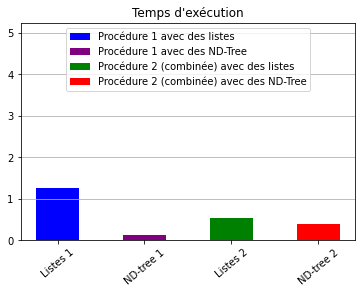

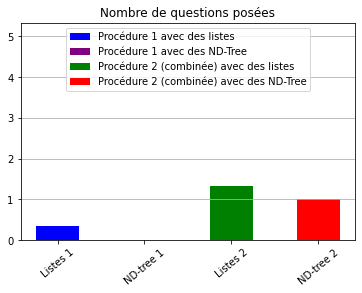

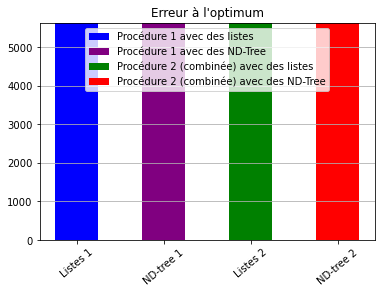

La première procèdure avec des liste met en moyenne un temps :  1.2450254758199055 , pose  0.3333333333333333  question(s), et a une erreur de  5633.304130805264
La première procèdure avec des NDtre met en moyenne un temps :  0.12739404042561847 , pose  0.0  question(s), et a une erreur de  5633.304130805264
La deuxième procèdure avec des liste met en moyenne un temps :  0.5297179222106934 , pose  1.3333333333333333  question(s), et a une erreur de  5633.304130805264
La deuxième procèdure avec des NDtre met en moyenne un temps :  0.38822491963704425 , pose  1.0  question(s), et a une erreur de  5633.304130805264


In [22]:
# Tests
# Instance partielle (20 objets, 3 critères) :
nbObjets = 20
nbCriteres = 3
n, W, w, v = LectureInstanceParticuliere("2KP200-TA-0.dat", nbObjets, nbCriteres)
fctAgregation = "OWA"
tmpsProc1List, tmpsProc1ND, tmpsProc2List, tmpsProc2ND, nbQuestProc1List, nbQuestProc1ND, nbQuestProc2List, nbQuestProc2ND, errOptiProc1List, errOptiProc1ND, errOptiProc2List, errOptiProc2ND = ComparaisonsMéthodes(W, w, v, fctAgregation, nbRep=3, verbose=False)
print("La première procèdure avec des liste met en moyenne un temps : ", tmpsProc1List, ", pose ", nbQuestProc1List, " question(s), et a une erreur de ", errOptiProc1List)
print("La première procèdure avec des NDtre met en moyenne un temps : ", tmpsProc1ND, ", pose ", nbQuestProc1ND, " question(s), et a une erreur de ", errOptiProc1ND)
print("La deuxième procèdure avec des liste met en moyenne un temps : ", tmpsProc2List, ", pose ", nbQuestProc2List, " question(s), et a une erreur de ", errOptiProc2List)
print("La deuxième procèdure avec des NDtre met en moyenne un temps : ", tmpsProc2ND, ", pose ", nbQuestProc2ND, " question(s), et a une erreur de ", errOptiProc2ND)

In [86]:
# PB erreurs négatives !? Impossible -> mm solution, pas mm cout soit disant
                                    #-> la somme de la fct obj dans le PL donne la mm valeur que valOpti

# PB enlever les TME